# Detección de tweets meteorológicos con Bag of Words

In [228]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

#### Cargo la base de datos clasificada y genero las variables de importancia

In [229]:
TW = pd.read_csv('datos_corr.csv')

In [230]:
TW.keys()[-3:]

Index(['Tag', 'Num', 'Nombre'], dtype='object')

In [231]:
MSJ = TW['Twit']
TAG = TW['Tag']
NUM = TW['Num']

In [232]:
MSJ

0                                         Esta lloviendo
1      quiero ir al centro a la mañana pero seguro ll...
2                   @paloma_CAI7 Si, llueve y mucho !! 😒
3                       @rozalazar9 Si llueve les hago 🤗
4      Hasta cuándo le voy a seguir teniendo miedo a ...
5      13h ClimaRafaela: Temp. 20.9 °C, Hum. 48 %, Ba...
6      @Eze2450 Sea la estación que sea , no hay plat...
7      Llueve y no tengo Internet...me espera tremend...
8                            Que linda noche de lluvia 💖
9      Miércoles de mucho calor, previo a las lluvias...
10     Me gusta cuando llueve porque parece que se es...
11     Noviembre sin ti es sentir que la lluvia me di...
12     17h Agvnet CDU: Temp. 32.4 °C, Hum. 33 %, Bar....
13      Con esta lluvia me dieron ganas de cucharear ! 😏
14                               Y se largo la lluvia ☔💕
15                                  Que hermosa tormenta
16                         @joaquinv17 dan lluvia jajaja
17     Aseguran que hay stock s

#### Elimino las cosas innecesarias de msj

In [233]:
def normalizacion(mensaje):
    
    mensaje = list(mensaje)
    lenght = len(mensaje)
    
    lista_ascii = [['\\xe1', '\\xe9', '\\xed', '\\xf3', '\\xfa', '\\xf1', '\\xd1', '\\xc1','\\xc9', '\\xcd', '\\xd3', 
                 '\\xda', '\\xa1', '\\xbf', '\\xdc', '\\xfc', '\\xb4', '\\xba', '\\xaa', '\\xb7','\\xc7','\\xe7',
                 '\\xa8', '\\xb0C', '\\n', '\\xb0c', '\\xbb', 'xb0', '\\ufe0f'],['a', 'e', 'i', 'o', 'u', 'ñ', 'Ñ', 'A', 'E', 'I', 'O', 'U', '', '', 'Ü', 'ü', '', 
                           ' ', '', '','Ç','ç','', ' ', ' ', ' ', ' ', ' ', ' ']]
    lista_simb = ['!','\'', '\"', "|", '$', "%", "&", "(", ")", "=", "?", "+",'/', ";", "_", "-", "1","2","3","4","5","6","7","8","9","0", '*',',', '.', ':', '#']
    
    ign_palabras = ['mbar','cdu','s','la','lo','st','que','este', 'me','t','p','el','weathercloud','en','h','temp','hpa','km','mm',"su","vos",'que',"re","xq","le","te","tu","soy","sos","mi","da","o","x","les","me","d","q", "como", "lo", "los", "mi", "son", "a", "el", 
                    "un","la", "una","en","por","para", 'las',"ante", "al", 'me',"rt", "del", "y", "se", "de", "que", "sus", "ha", "es", "con", "esta"]
    
    for i in range(lenght):
        
        ## Convierto mayúsculas en minúsculas
        mensaje[i] = mensaje[i].lower()
        
        ## Saco las menciones y otras cosas
        txt = mensaje[i].split()
        
        for j in range(len(txt)):
            if ('@' in txt[j]) and ('RELAMPAGO2018' not in txt[j]) and ('RELAMPAGO_edu' not in txt[j]) or ('jaj' in txt[j]) or ('https' in txt[j]): txt[j]=''
        
        mensaje[i] = " ".join(txt)
        
        ## Reemplazo símbolos
        for h in range(len(lista_simb)):
            mensaje[i] = mensaje[i].replace(lista_simb[h], ' ')
            
        ## Convierto el msj a ASCII, reemplazo los errores de decodificación y agrego un espacio antes de cada decodificación
        mensaje[i] = mensaje[i].encode('unicode-escape').decode('ASCII')+" "     
        
        for j in range(len(lista_ascii[0])):
            mensaje[i] = mensaje[i].replace(lista_ascii[0][j], lista_ascii[1][j])
        
        mensaje[i] = mensaje[i].replace('\\', ' \\')
        
        for j in range(len(ign_palabras)):
            mensaje[i] = mensaje[i].replace(" "+ign_palabras[j]+" ", ' ')
        
    return(mensaje)

In [234]:
msj = normalizacion(MSJ)

In [235]:
msj

['esta lloviendo ',
 'quiero ir centro mañana pero seguro llueve  ',
 ' si  llueve mucho     \\U0001f612 ',
 ' si llueve hago  \\U0001f917 ',
 'hasta cuando voy seguir teniendo miedo tormentas   \\U0001f644 \\U0001f623 ',
 '  climarafaela           hum        bar          lluvia      viento      sso  ',
 ' sea estacion sea   no hay plata  ahora llueve   cambia   tenes estudiar igual ',
 'llueve no tengo internet   espera tremenda tarde ',
 'que linda noche lluvia  \\U0001f496 ',
 'miercoles mucho calor  previo lluvias  ',
 'me gusta cuando llueve porque parece estan fritando empanadas  puesgorda  \\U0001f602 ',
 'noviembre sin ti sentir lluvia dice llorando todo acabo  \\U0001f3b5 ',
 '  agvnet           hum        bar         lluvia    viento       ',
 'con lluvia dieron ganas cucharear    \\U0001f60f ',
 'y largo lluvia  \\u2614 \\U0001f495 ',
 'que hermosa tormenta ',
 ' dan lluvia  ',
 'aseguran hay stock suficiente bengalas combatir tormentas  ',
 'aprobe final    tome cervezas am

#### División en datasets de  _train_ y _test_

In [236]:
size = 0.8

## Toma los tweets, los asocia con su tag y luego los divide en cada una de las palabras que los componen
## zip() itera tuplas
train = [(i.split(),j) for i,j in zip(list(msj)[1:int(len(msj)*0.8)],list(TAG)[1:int(len(msj)*0.8)])]

test = [(i.split(),j) for i,j in zip(list(msj)[int(len(msj)*0.8)+1:len(msj)],list(TAG)[int(len(msj)*0.8)+1:len(msj)])]

## No entiendo bien que es esto
label_to_ix = { 1: 0, 0: 1 }

#### Generación del diccionario con el dataset completo

In [237]:
word_to_ix = {}

## Cada palabra que encuentra la guarda en un diccionario
for sent, _ in train+test:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

VOCAB_SIZE = len(word_to_ix)
NUM_LABELS = 2

#### Bag of Words

In [238]:
class BoWClassifier(nn.Module): # inheriting from nn.Module!
    
    def __init__(self, num_labels, vocab_size):
        
        super(BoWClassifier, self).__init__()

        self.linear = nn.Linear(vocab_size, num_labels)
        
        
    def forward(self, bow_vec):
        # Pass the input through the linear layer,
        # then pass that through log_softmax.
        # Many non-linearities and other functions are in torch.nn.functional
        return F.log_softmax(self.linear(bow_vec), dim=1)
    
    def make_bow_vector(sentence, word_to_ix):
        vec = torch.zeros(len(word_to_ix))
        for word in sentence:
            vec[word_to_ix[word]] += 1
        return vec.view(1, -1)

    def make_target(label, label_to_ix):
        
        return torch.LongTensor([label_to_ix[label]])
    
model = BoWClassifier(NUM_LABELS, VOCAB_SIZE)

Ejemplo de BoWClassifier

In [239]:
## Tomo un tweet
sample = train[0]
print (sample)

## Genera el BowVector, es del largo del diccionario y tiene unos en las posiciones donde las palabras del tweet coinciden con el diccionario
bow_vector = BoWClassifier.make_bow_vector(sample[0], word_to_ix)
print(bow_vector)

## Aplico el modelo y obtengo la probabilidad de que el tweet sea meteorológico o no meteorológico
log_probs = model(bow_vector)
print (log_probs.exp())

(['quiero', 'ir', 'centro', 'mañana', 'pero', 'seguro', 'llueve'], 0)
tensor([[1., 1., 1.,  ..., 0., 0., 0.]])
tensor([[0.5023, 0.4977]], grad_fn=<ExpBackward>)


#### Miremos la frecuencia de ocurrencia de palabras en el diccionario

In [240]:
vec = torch.zeros(len(word_to_ix))
for i, label in test+train:
    bow_vector = BoWClassifier.make_bow_vector(i, word_to_ix)
    vec = vec.add(bow_vector)

vec=vec[0].tolist()

In [242]:
## Genero un dataframe que me pemite ordenar de mayor a menor respecto de la columna Frecuencia
tot = pd.DataFrame()
tot['Diccionario'] = list(word_to_ix.keys())
tot['Frecuencia'] = vec
tot['Num'] = word_to_ix.values()
tot = tot.sort_values(by=['Frecuencia'], ascending=False)
tot[0:100]

,Diccionario,Frecuencia,Num
24,lluvia,332.0,24
29,no,113.0,29
6,llueve,96.0,6
79,tormenta,77.0,79
7,si,49.0,7
42,que,47.0,42
203,\U0001f60d,43.0,203
231,dormir,38.0,231
4,pero,36.0,4
25,viento,35.0,25


#### Aplicamos el BoW

In [243]:
# Run on test data before we train, just to see a before-and-after
for instance, label in test:
    bow_vec = BoWClassifier.make_bow_vector(instance, word_to_ix)
    log_probs = model(bow_vec)
    print (log_probs.exp(), label)
print (next(model.parameters())[:,word_to_ix["lluvia"]])

tensor([[0.5102, 0.4898]], grad_fn=<ExpBackward>) 1
tensor([[0.4995, 0.5005]], grad_fn=<ExpBackward>) 0
tensor([[0.5350, 0.4650]], grad_fn=<ExpBackward>) 0
tensor([[0.5411, 0.4589]], grad_fn=<ExpBackward>) 0
tensor([[0.5483, 0.4517]], grad_fn=<ExpBackward>) 0
tensor([[0.5160, 0.4840]], grad_fn=<ExpBackward>) 0
tensor([[0.5109, 0.4891]], grad_fn=<ExpBackward>) 0
tensor([[0.5036, 0.4964]], grad_fn=<ExpBackward>) 0
tensor([[0.5002, 0.4998]], grad_fn=<ExpBackward>) 0
tensor([[0.5096, 0.4904]], grad_fn=<ExpBackward>) 0
tensor([[0.5077, 0.4923]], grad_fn=<ExpBackward>) 0
tensor([[0.5097, 0.4903]], grad_fn=<ExpBackward>) 0
tensor([[0.5104, 0.4896]], grad_fn=<ExpBackward>) 0
tensor([[0.5089, 0.4911]], grad_fn=<ExpBackward>) 1
tensor([[0.5055, 0.4945]], grad_fn=<ExpBackward>) 0
tensor([[0.5324, 0.4676]], grad_fn=<ExpBackward>) 0
tensor([[0.5108, 0.4892]], grad_fn=<ExpBackward>) 1
tensor([[0.5162, 0.4838]], grad_fn=<ExpBackward>) 1
tensor([[0.5179, 0.4821]], grad_fn=<ExpBackward>) 1
tensor([[0.5

In [244]:
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Usually you want to pass over the training data several times.
# 100 is much bigger than on a real data set, but real datasets have more than
# two instances.  Usually, somewhere between 5 and 30 epochs is reasonable.
for epoch in range(700):
    if epoch % 50 == 0: print('Epoch: %i' %epoch)
    for instance, label in train:
        # Step 1. Remember that Pytorch accumulates gradients.  We need to clear them out
        # before each instance
        model.zero_grad()
    
        # Step 2. Make our BOW vector and also we must wrap the target in a Variable
        # as an integer.  For example, if the target is SPANISH, then we wrap the integer
        # 0.  The loss function then knows that the 0th element of the log probabilities is
        # the log probability corresponding to SPANISH
        bow_vec = BoWClassifier.make_bow_vector(instance, word_to_ix)
        target = BoWClassifier.make_target(label, label_to_ix)
    
        # Step 3. Run our forward pass.
        log_probs = model(bow_vec)
    
        # Step 4. Compute the loss, gradients, and update the parameters by calling
        # optimizer.step()
        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()

Epoch: 0
Epoch: 50
Epoch: 100
Epoch: 150
Epoch: 200
Epoch: 250
Epoch: 300
Epoch: 350
Epoch: 400
Epoch: 450
Epoch: 500
Epoch: 550
Epoch: 600
Epoch: 650


 tensor([[0.9925, 0.0075]], grad_fn=<ExpBackward>) 1
 tensor([[0.0460, 0.9540]], grad_fn=<ExpBackward>) 0
 tensor([[1.9962e-04, 9.9980e-01]], grad_fn=<ExpBackward>) 0
 tensor([[0.0058, 0.9942]], grad_fn=<ExpBackward>) 0
 tensor([[0.0038, 0.9962]], grad_fn=<ExpBackward>) 0
 tensor([[1.1321e-05, 9.9999e-01]], grad_fn=<ExpBackward>) 0
 tensor([[0.9802, 0.0198]], grad_fn=<ExpBackward>) 0
 tensor([[0.9118, 0.0882]], grad_fn=<ExpBackward>) 0
 tensor([[1.2440e-06, 1.0000e+00]], grad_fn=<ExpBackward>) 0
 tensor([[0.0134, 0.9866]], grad_fn=<ExpBackward>) 0
 tensor([[0.0387, 0.9613]], grad_fn=<ExpBackward>) 0
 tensor([[3.4541e-04, 9.9965e-01]], grad_fn=<ExpBackward>) 0
 tensor([[0.0146, 0.9854]], grad_fn=<ExpBackward>) 0
 tensor([[0.5554, 0.4446]], grad_fn=<ExpBackward>) 1
 tensor([[0.4575, 0.5425]], grad_fn=<ExpBackward>) 0
 tensor([[0.1393, 0.8607]], grad_fn=<ExpBackward>) 0
 tensor([[0.0396, 0.9604]], grad_fn=<ExpBackward>) 1
 tensor([[0.9926, 0.0074]], grad_fn=<ExpBackward>) 1
 tensor([[0.99

Text(0,0.5,'Cantidad de aciertos. Total=118')

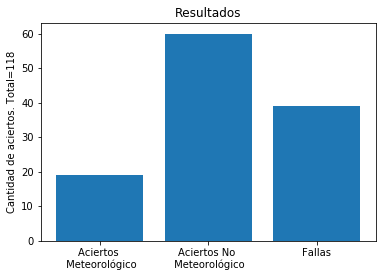

In [260]:
c = [0,0,0]
for instance, label in test:
    bow_vec = autograd.Variable(BoWClassifier.make_bow_vector(instance, word_to_ix))
    log_probs = model(bow_vec)
    log_probs_exp = log_probs.exp()
    if bool (log_probs_exp[0][0]>0.5) and (label == 1):
        c[0]+=1
        print ('\033[1;93m' , log_probs_exp , label)
    elif bool (log_probs_exp[0][1]>0.5) and (label == 0):
        c[1]+=1
        print ('\033[1;32m' , log_probs_exp , label)
    else:
        c[2]+=1
        print ('\033[1;31m' , log_probs_exp , label)
 
print('\033[0m Aciertos a tweets meteorológicos:', round((c[0]/sum(c))*100, 3),'% \n Aciertos a tweets no meteorologicos:', round((c[1]/sum(c))*100, 3), '% \n Fallas: ', round((c[2]/sum(c))*100, 3),'%') 
print(c)
#print ('\033[0m', next(model.parameters())[:,word_to_ix["lluvia"]]) # Index corresponding to Spanish goes up, English goes down!

plt.bar(range(3),c, tick_label=['Aciertos \n Meteorológico','Aciertos No \n Meteorológico','Fallas'])
plt.title('Resultados')
plt.ylabel('Cantidad de aciertos. Total='+str(sum(c)))
